#### Part 1 - Defining class for KMeans

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
class KMeans:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        
    def fit(self, train_x, random_state = 0):
        m = train_x.shape[0]
        np.random.seed(random_state)
        self.centroids = train_x[np.random.choice(m,self.n_clusters,replace=False)]
        while True:
            old_centroids = self.centroids.copy()
            self.labels = self.predict(train_x)
            for cluster_id in range(self.n_clusters):
                cluster = train_x[self.labels == cluster_id]
                if len(cluster):
                    self.centroids[cluster_id] = cluster.mean(axis=0)
            if np.all(old_centroids != self.centroids) : break
                
    def predict(self, points):
        return np.argmin(cdist(points,self.centroids),axis=-1)

#### Part 2 - Defining evaluation metrics

In [3]:
def distortion(X,labels,centroids):
    _, label_codes = np.unique(labels,return_inverse=True)
    return np.linalg.norm((X-centroids[label_codes]),axis=-1).mean()

def silhouette_score(X, labels):
    m = X.shape[0]
    clusters = np.unique(labels)
    n_clusters = clusters.shape[0]
    if n_clusters == 1: return -1
    cluster_codes = np.arange(n_clusters)
    dist_mask = labels.reshape(-1,1) == \
        ((labels + cluster_codes.reshape(-1,1))%n_clusters)[:,np.newaxis,:]
    dist_mask[0][np.eye(m).astype(bool)] = 0
    dist_mat = cdist(X,X)
    mean_dist = (dist_mask*dist_mat).sum(axis=-1)/dist_mask.sum(axis=-1)
    A = mean_dist[0]
    B = np.min(mean_dist[1:],axis=0)
    return ((B-A)/np.max(np.dstack([A,B]),axis=-1)).mean()

#### Part 3 - Loading the iris dataset

In [4]:
names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
iris_df = pd.read_csv('./datasets/iris.csv', header=None, names=names)
display(iris_df.head())
print(
    f"The data set contains {iris_df.shape[0]} records "
    f"and {iris_df.shape[1]} features.",
    iris_df['species'].value_counts(), sep="\n"
)


,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The data set contains 150 records and 5 features.
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64


#### Part 4 - Implementing K-means Clustering

In [5]:
train_x = iris_df.drop("species", axis=1).values
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(train_x)
all_df = iris_df.copy(deep = True)
centroids = pd.DataFrame(kmeans.centroids, columns=names[:-1])
centroids["cluster"] = "centroid"
all_df['cluster'] = kmeans.labels.astype("str")
all_df = pd.concat([all_df, centroids])

#### Part 5 - Comparing the Clustering results with original classes

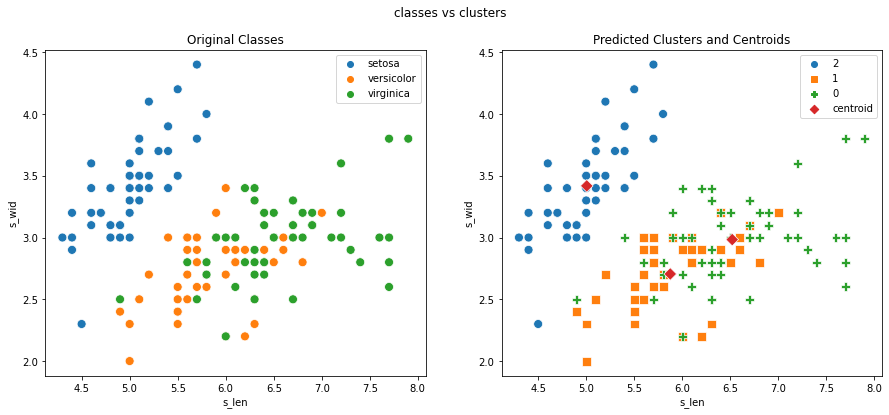

In [6]:
plt.figure(figsize=(15,6))
plt.suptitle("classes vs clusters")
plt.subplot(121)
plt.title("Original Classes")
sns.scatterplot(data=all_df,x="s_len",y="s_wid",hue="species",s=80)
plt.legend(loc="upper right")

plt.subplot(122)
plt.title("Predicted Clusters and Centroids")
sns.scatterplot(
    data=all_df,x="s_len",y="s_wid",
    hue="cluster",style = "cluster",
    markers="osPD",s=80
)
plt.legend(loc="upper right")

plt.show()

#### Part 6 - Testing with multiple values of k(Hyperparameter tuning)

In [7]:
sil_coefs = []
distortions = []
K = np.arange(2,6)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_x)
    avg_sil_coef = silhouette_score(train_x,kmeans.labels)
    dist = distortion(train_x,kmeans.labels,kmeans.centroids)
    print(f"For k={k:<4} Avg.Sil.Coef: {avg_sil_coef:<10.5f} Distortion: {dist:.5f}")
    distortions.append(dist)
    sil_coefs.append(avg_sil_coef)

For k=2    Avg.Sil.Coef: 0.41657    Distortion: 1.30604
For k=3    Avg.Sil.Coef: 0.49127    Distortion: 0.67576
For k=4    Avg.Sil.Coef: 0.45307    Distortion: 0.59402
For k=5    Avg.Sil.Coef: 0.32360    Distortion: 0.56721


#### Part 7 - Using Elbow method to Find the optimal value of k

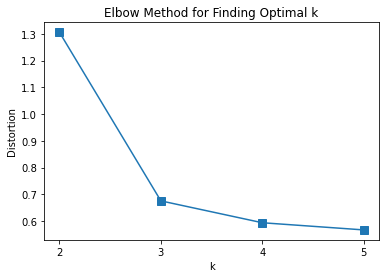

In [8]:
plt.plot(K, distortions, 's-', markersize=8)
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

#### Part 8 -  Implementing K-means clustering with scikit learn

In [9]:
from sklearn.cluster import KMeans as sklKMeans
from sklearn.metrics import silhouette_score as sk_silhouette_score

In [10]:
k = 3
kmeans = sklKMeans(n_clusters=k, init='random').fit(train_x)
ss = sk_silhouette_score(train_x, kmeans.labels_)
dist = distortion(train_x,kmeans.labels_, kmeans.cluster_centers_)
print(f"For k={k}\tAvg. Sil. Coef: {ss:.5f}\tDistortion: {dist:.5f}")

For k=3	Avg. Sil. Coef: 0.55259	Distortion: 0.64884
